# A CNN-VRNN Model for Polyphonic Music Generation

This notebook implements the CNN-VRNN model which can be used to generate novel samples of music based on a given piece of music.

- You can change the song being trained on by changing the file being pointed to by `input_song_file` in the first cell.
- Change the model file by changing `checkpoint_file` in the first cell.
- Tensorboard event files will be output to the tb/ directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pretty_midi
import librosa
from datetime import datetime
from util.tensorflow import rnn

%matplotlib inline
from IPython.display import Audio, display

checkpoint_file = './tfmodel/vae_sonic_conditional_gru_iter2000.tfmodel'
input_song_file = './audio_files/vgmusic/sonic_starlight_zone.mid'

/home/dustin.wright37/python_envs/p3MachineLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


## Load the song
Change `fs` to change the input beat resolution.

In [3]:
pm = pretty_midi.PrettyMIDI(input_song_file)
initial_tempo = pm.get_tempo_changes()[1][0]
fs = (initial_tempo / 60) * 8
piano_roll = pm.get_piano_roll(fs=fs)
piano_roll = (piano_roll.T > 0).astype(np.float32)

/home/dustin.wright37/python_envs/p3MachineLearning/lib/python3.5/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


## Set up constants
Change the constants in this cell to alter the parameters of the network (hidden layer sizes, number of epochs to run, midi frame size, etc.)

In [4]:
num_timesteps = int(fs)
note_range = 128
T = 16
num_batches = int(piano_roll.shape[0] // (fs * T))
height = num_timesteps
width = note_range
n_visible = note_range * num_timesteps
num_epochs = 2000

z_dim = 512
n_hidden = z_dim
X_dim = width * height
h_dim = n_hidden

initializer = tf.contrib.layers.xavier_initializer()

audio_sr = 44100

## Helper functions/models

In [5]:
def gru(inputs, size=512, initial_state=None, name="gru", reuse=False, dtype=tf.float32):
    with tf.variable_scope(name, reuse=reuse) as scope:
        cell = tf.contrib.rnn.GRUCell(size, reuse=reuse)
        input_shape = tf.shape(inputs)

        if initial_state is None:
            initial_state = cell.zero_state(batch_size=input_shape[0], dtype=dtype)

        outputs,state = tf.nn.dynamic_rnn(cell, inputs, 
                            initial_state=initial_state, dtype=dtype)
        return outputs, state
    
def conditional_gru(inputs, size=512, keep_prob=1.0, name="conditional_gru", initial_state=None, reuse=False, dtype=tf.float32):
    with tf.variable_scope(name, reuse=reuse):
        cell = rnn.ConditionalGRU(size, reuse=tf.get_variable_scope().reuse)
        input_shape = tf.shape(inputs)
        
        if initial_state is None:
            initial_state = cell.zero_state(batch_size=input_shape[0], dtype=dtype)
            
        outputs, state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state, dtype=dtype)
        
        return outputs, state
    
def conv_relu_pool(inputs, kernel_shape, pool_shape, name="conv2d", reuse=False, dtype=tf.float32):
    with tf.variable_scope(name) as scope:
        conv_kernel = tf.get_variable('conv2d', shape=kernel_shape, initializer=initializer, dtype=dtype)
        conv_bias = tf.get_variable('conv2d_b', shape=kernel_shape[3], dtype=dtype)
        
        conv = tf.nn.conv2d(inputs, conv_kernel, [1,1,1,1], "VALID")
        preact = tf.nn.bias_add(conv, conv_bias)
        relu = tf.nn.relu(preact)
        pool = tf.nn.max_pool(relu, pool_shape, pool_shape, "VALID")

        return pool

In [6]:
def midi_latent_feature(X, keep_prob=1.0, name='latent_feauture', reuse=False):
    with tf.variable_scope(name, reuse=reuse) as scope:
        conv1_out = conv_relu_pool(X, 
                                   kernel_shape=[2,2,1,32],
                                   pool_shape=[1, 2, 2, 1],
                                   name="conv_1")

        conv2_out = conv_relu_pool(conv1_out, 
                                   kernel_shape=[2, 2 , 32 , 32],
                                   pool_shape=[1, 2, 2, 1],
                                   name="conv_2")

        h = tf.contrib.layers.flatten(conv2_out)

        return tf.nn.dropout(h, keep_prob=keep_prob)

def Q(X, name_scope="Encoder", keep_prob=1.0):
    with tf.name_scope(name_scope):
        with tf.name_scope("Encoder_RNN"):
            #Expand dims for rnn to [1, T, k]
            rnn_in = tf.expand_dims(X, 0)
            rnn_outs, rnn_state = gru(rnn_in, size=z_dim, name="gru_enc")
            #Reshape
            rnn_state = tf.reshape(rnn_state[-1,:], [1, z_dim])
        
        with tf.name_scope("Calculate_mu_sigma"):
            Q_W2_mu = tf.get_variable('encoder_mean_weights', shape=[z_dim, z_dim], initializer=initializer)
            Q_b2_mu = tf.get_variable('encoder_mean_bias', shape=[z_dim], initializer=initializer)

            Q_W2_sigma = tf.get_variable('encoder_variance_weights', shape=[z_dim, z_dim], initializer=initializer)
            Q_b2_sigma = tf.get_variable('encoder_variance_bias', shape=[z_dim], initializer=initializer)
            #KL divergence with last GRU state
            z_mu = tf.matmul(rnn_state, Q_W2_mu) + Q_b2_mu
            z_logvar = tf.matmul(rnn_state, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

def sample_z(mu, log_var):
    with tf.name_scope("Random_samples"):
        eps = tf.random_normal(shape=tf.shape(mu))
        return mu + tf.exp(log_var / 2) * eps

In [7]:
def P(z, name_scope="Decoder", xt=None, keep_prob=1.0, reuse=False):
    with tf.name_scope(name_scope):
        with tf.name_scope("expand_input"):
            xt_in = tf.zeros([1, z_dim], dtype=tf.float32)
            #Expand dims for RNN
            if xt is not None:
                #Used to transform CNN representation
                P_W1 = tf.get_variable('P_W1', shape=[xt.get_shape().as_list()[1], z_dim], initializer=initializer)
                P_b1 = tf.get_variable('P_b1', shape=[z_dim], initializer=initializer)
                xt_ = tf.matmul(xt, P_W1) + P_b1
                #Make the initial state all 0, just use conditioning noise
                xt_in = tf.concat([xt_in, xt_], axis=0)
            xt_in = tf.expand_dims(xt_in, 0)

        with tf.name_scope("Decoder_RNN"):
            #Condition on the noise z
            z = tf.reshape(z, [1, z_dim])
            dec_init_state = rnn.ConditionalGRUState(h=tf.zeros([1, h_dim], dtype=tf.float32), c=z)
            dec_outs, _ = conditional_gru(xt_in, size=h_dim, name="gru_dec", reuse=reuse, initial_state=dec_init_state)
            dec_outs = tf.reshape(dec_outs, [-1, h_dim])

            drop = tf.nn.dropout(dec_outs, keep_prob=keep_prob)

            P_W2 = tf.get_variable('P_W2', shape=[h_dim, X_dim], initializer=initializer)
            P_b2 = tf.get_variable('P_b2', shape=[X_dim], initializer=initializer)

        logits = tf.matmul(drop, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits

## VAE-RNN model

In [8]:
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Generated_noise")
z_rnn_samples = tf.placeholder(tf.float32, shape=[None, height, width, 1], name="Generated_midi_input")

X = tf.placeholder(tf.float32, shape=[None, height, width, 1], name="Training_samples")

kl_annealing = tf.placeholder(tf.float32, name="KL_annealing_multiplier")

with tf.variable_scope('vae_rnn') as scope:
    
    latent_feature_enc = midi_latent_feature(X, name='CNN_Encoder')
    #latent_feature_dec = midi_latent_feature(X, name='cnn_dec')

    z_mu, z_logvar = Q(latent_feature_enc, name_scope="Encoder_train")
    z_sample = sample_z(z_mu, z_logvar)

    out_samples, logits = P(z_sample, name_scope="Decoder_train", xt=latent_feature_enc[:-1])

    # Sampling from random z
    scope.reuse_variables()
    latent_z_rnn = midi_latent_feature(z_rnn_samples, name='CNN_Encoder', reuse=True)
    X_samples, _ = P(z, name_scope="Decoder_test", xt=latent_z_rnn, reuse=True)

with tf.name_scope("Loss"):
    X_labels = tf.reshape(X, [-1, width*height])

    with tf.name_scope("cross_entropy"):
        recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X_labels), 1)
    with tf.name_scope("kl_divergence"):
        kl_loss = kl_annealing * 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_logvar) - tf.log(tf.square(z_logvar)) - 1,1) 
    
    loss = tf.reduce_mean(recon_loss + kl_loss)

with tf.name_scope("Optimizer"):
    solver = tf.train.AdamOptimizer()
    grads = solver.compute_gradients(loss)
    grads = [(tf.clip_by_norm(g, clip_norm=10), v) for g, v in grads]
    train_op = solver.apply_gradients(grads)

In [9]:
with tf.name_scope("Logging"):
    recon_loss_ph = tf.placeholder(tf.float32)
    kl_loss_ph = tf.placeholder(tf.float32)
    loss_ph = tf.placeholder(tf.float32)
    audio_ph = tf.placeholder(tf.float32)

    tf.summary.scalar("Reconstruction_loss", recon_loss_ph)
    tf.summary.scalar("KL_loss", kl_loss_ph)
    tf.summary.scalar("Loss", loss_ph)
    tf.summary.audio("sample_output", audio_ph, audio_sr)
    log_op = tf.summary.merge_all()

writer = tf.summary.FileWriter('./tb/', graph=tf.get_default_graph())

In [10]:
def annealing_sched(epoch):
    return np.min([0.01*epoch, 1.])

In [11]:
saver = tf.train.Saver()

## Training

Iter:  0
Loss:  831.9597
KL Loss: [144.65968]
Recon Loss [1161.8164   765.9846   693.4912   673.1836   662.1201   639.44214
  652.646    645.16895  678.3146   627.29736  640.23047  630.9601
  648.9445   634.74646  621.82104  620.63403]


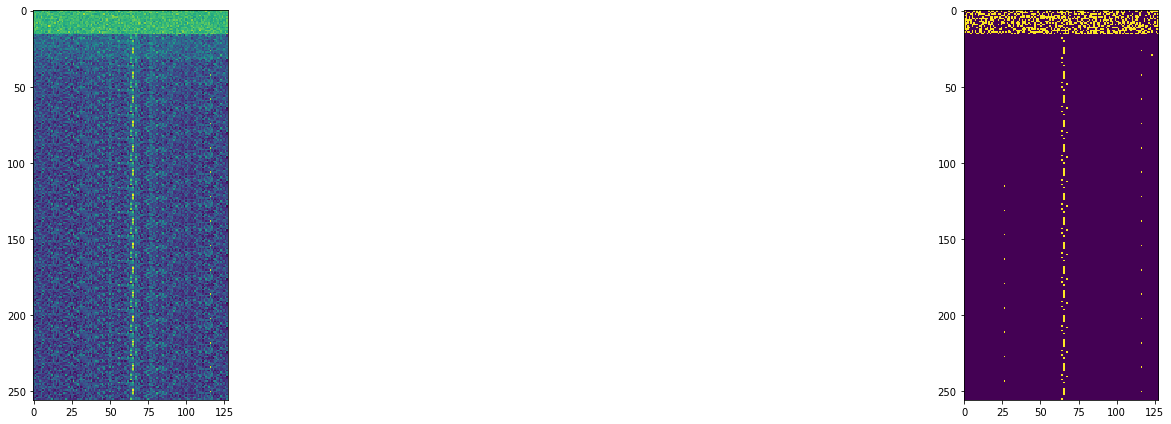

Iter:  100
Loss:  130.42886
KL Loss: [8.75935]
Recon Loss [212.07227   85.97722   87.33725  118.76277  128.33376  106.4531
 131.31537  145.44128  245.16946  103.27881   95.54253  119.404976
 159.45425  101.49331   46.250404  60.425377]


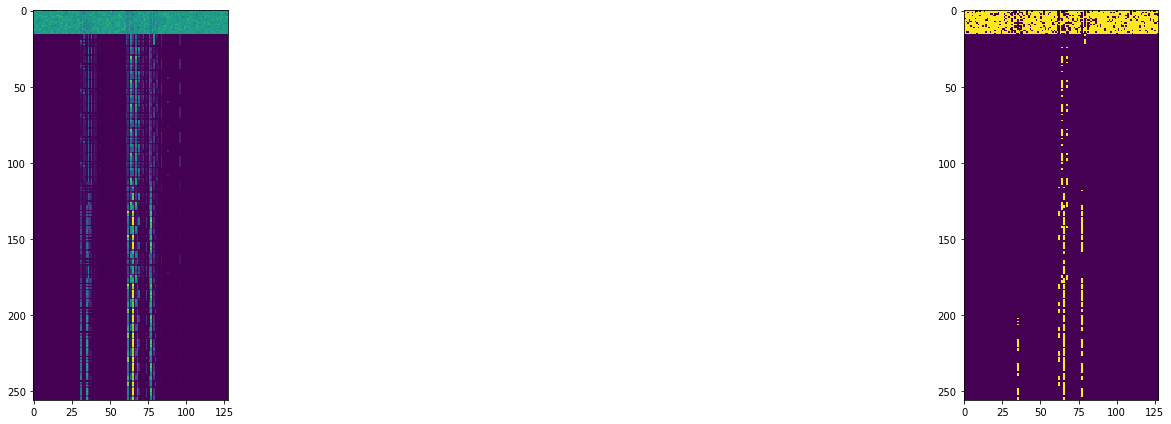

Iter:  200
Loss:  18.075153
KL Loss: [2.6018548]
Recon Loss [100.179924    8.850015   11.2819     12.140168   10.333749   10.910268
  17.932045   19.780733   20.019182    5.960587    4.7540693   6.862647
   7.744687    4.56123     2.8580668   3.4035113]


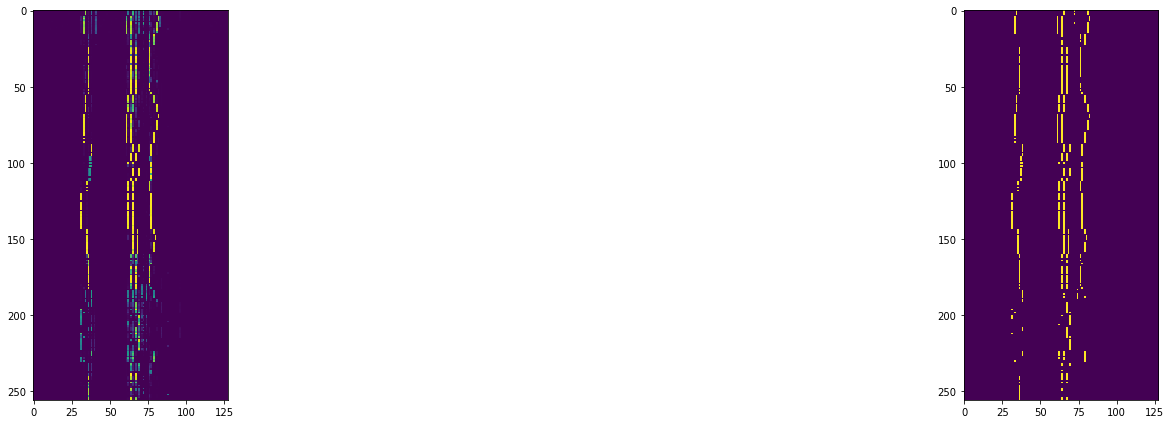

Iter:  300
Loss:  17.877462
KL Loss: [4.257761]
Recon Loss [173.84247     3.5574615   2.468348    2.8824508   2.7849848   3.6910768
   3.310103    6.5569563   5.618879    1.8092551   1.3011241   2.4381936
   2.7694864   1.4660473   1.9298512   1.4885435]


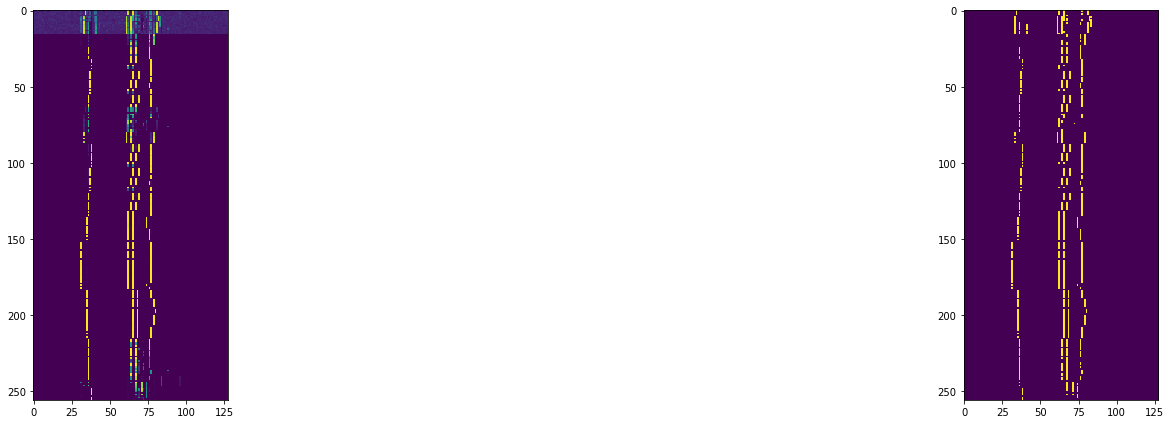

Iter:  400
Loss:  6.4011083
KL Loss: [3.0459592]
Recon Loss [34.300797   0.7289254  0.9315335  1.4959581  1.4110143  1.7586303
  1.7274597  3.0880537  2.683097   0.8499712  0.6275625  1.0592257
  1.015744   0.7550291  0.6478483  0.6015356]


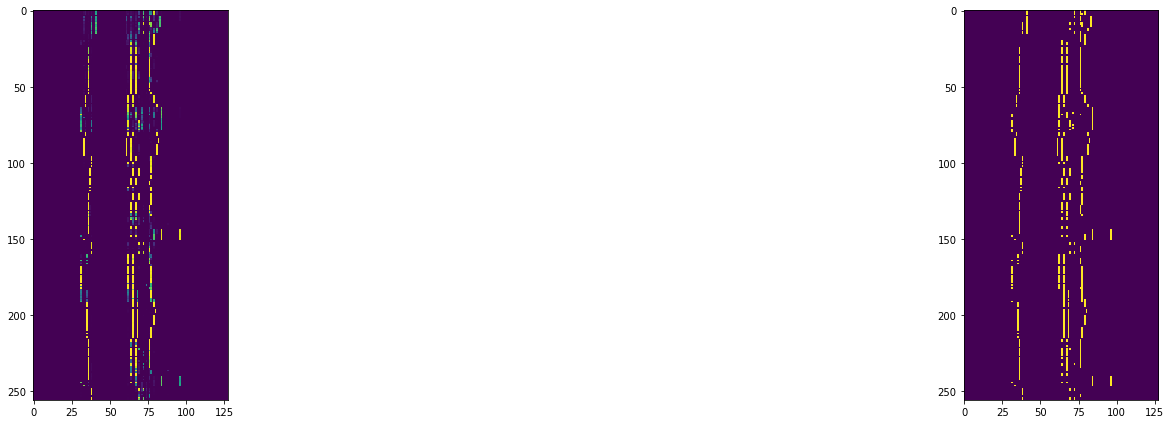

Iter:  500
Loss:  3.986571
KL Loss: [2.6210322]
Recon Loss [10.256246    0.6688383   0.45103726  0.66730875  0.91874516  1.0906069
  0.93288857  1.7497525   1.7711474   0.5553382   0.40623376  0.61208785
  0.7467183   0.4593731   0.30168402  0.2606143 ]


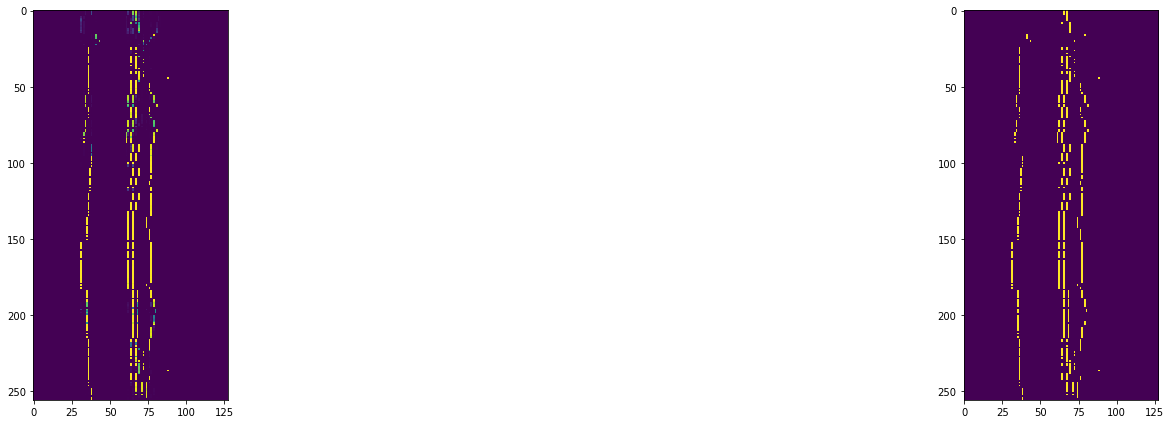

Iter:  600
Loss:  2.699387
KL Loss: [1.9666563]
Recon Loss [3.6407206  0.34751686 0.45998344 0.45818835 0.51811373 0.67505044
 0.66301453 1.486349   1.5379425  0.2971009  0.25634384 0.43188104
 0.3249985  0.22111528 0.17867553 0.22669797]


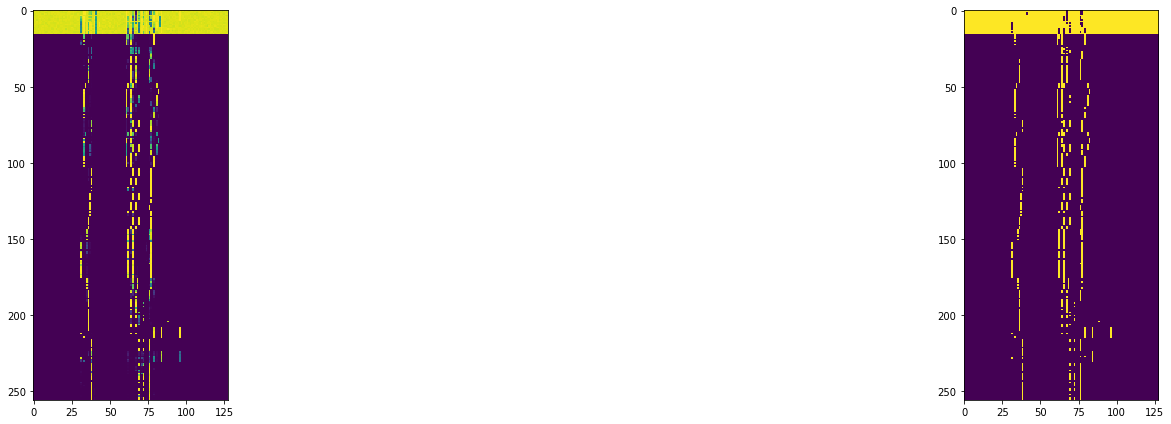

Iter:  700
Loss:  3.7517424
KL Loss: [3.2934637]
Recon Loss [1.2285091  0.30184236 0.34253076 0.33283734 0.49388152 0.49903023
 0.49567956 1.0223868  0.9959492  0.30329987 0.20611897 0.42783803
 0.19786371 0.23427634 0.11767257 0.13274063]


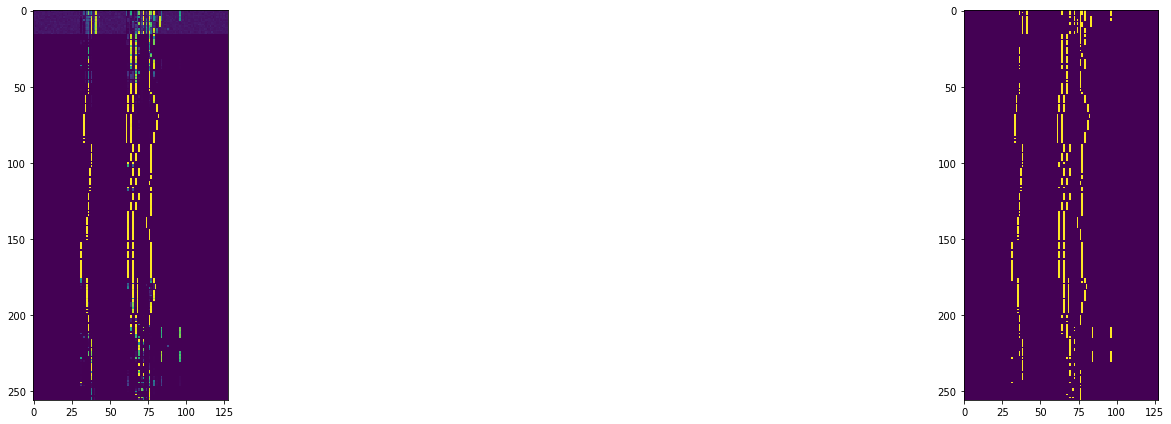

Iter:  800
Loss:  2.6460986
KL Loss: [2.2234359]
Recon Loss [1.5654533  0.16234954 0.18739782 0.26354426 0.25222883 0.6910338
 0.69433755 0.7256233  0.79501885 0.2336668  0.11927175 0.37100416
 0.23449768 0.20824136 0.11122115 0.14771181]


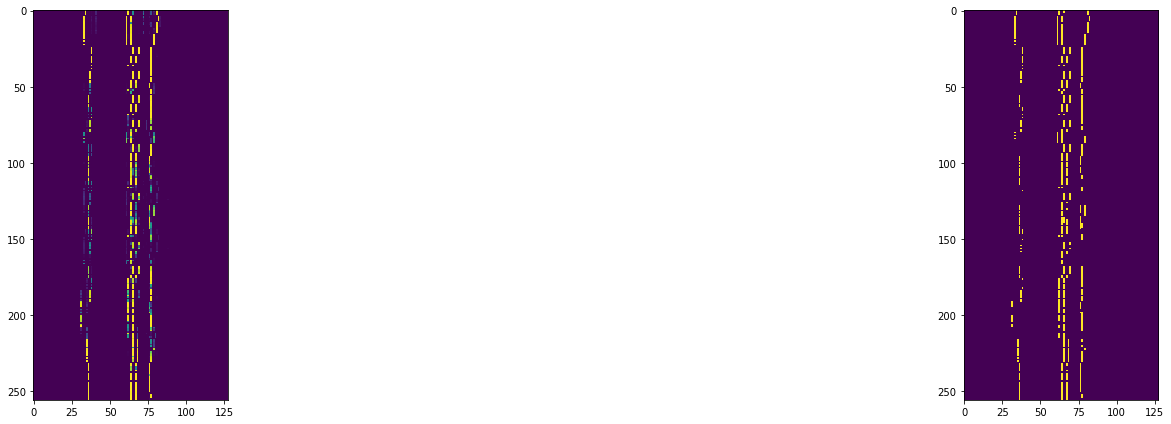

KeyboardInterrupt: 

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    while i <= num_epochs:
        #s = song[20:20+num_timesteps,:].reshape(1,num_timesteps*2*note_range)
        for b in range(num_batches):
            s = piano_roll[b*T*num_timesteps:(b+1)*T*num_timesteps, :note_range].reshape(T, height, width, 1)
            kla = annealing_sched(i)
            #X_mb = song[(ind*num_timesteps):num_timesteps*(ind + 1), :].reshape(1, height, width, 1)
            _,loss_out, kl, recon = sess.run([train_op, loss, kl_loss, recon_loss], feed_dict={X: s, kl_annealing: 1.0})

        if i % 100 == 0:
            print('Iter: ', i)
            print('Loss: ', loss_out)
            print('KL Loss:', kl)
            print('Recon Loss', recon)

            #Random samples
            z_in = np.random.randn(1, z_dim)
            z_rnn_out = np.zeros((1,height,width,1))
            first = True
            for j in range(T):
                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), z_rnn_samples: z_rnn_out})
                frames = j + 1
                if first:
                    frames = 2
                z_rnn_out = samples.reshape((frames, height, width, 1))
                if first:
                    z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
                    first = False
            samples = samples.reshape((num_timesteps*T, note_range))
            thresh_S = samples >= 0.5
            plt.figure(figsize=(36,6))
            plt.subplot(1,2,1)
            plt.imshow(samples)
            plt.subplot(1,2,2)
            plt.imshow(thresh_S)
            plt.tight_layout()
            plt.pause(0.1)
            
            pm_out = piano_roll_to_pretty_midi(thresh_S.T * 127, fs=fs)
            midi_out = './tb/audio/test002_{0}.mid'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            wav_out = './tb/audio/test002_{0}.wav'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            audio = pm_out.synthesize() 
            audio = audio.reshape((1, len(audio)))
            #Write out logs
            summary = sess.run(log_op, feed_dict={recon_loss_ph: np.mean(recon), kl_loss_ph: np.mean(kl),
                                                 loss_ph: loss_out, audio_ph: audio})
            writer.add_summary(summary, i)
        
        i += 1
        saver.save(sess, checkpoint_file)

## Testing

INFO:tensorflow:Restoring parameters from ./tfmodel/vae_sonic_onecnn_iter2000.tfmodel


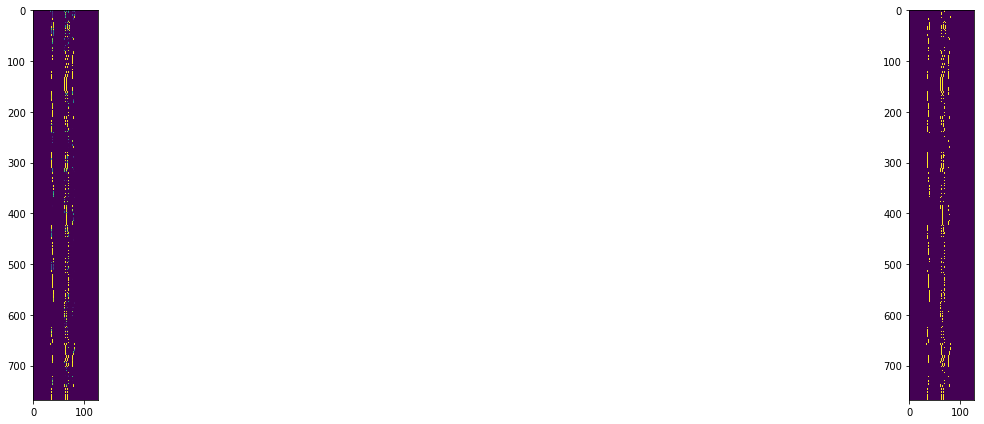

In [14]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_file)
    #Generate T frames
   
    #Random samples
    z_in = np.random.randn(1, z_dim)
    z_rnn_out = np.zeros((1,height,width,1))
    first = True
    for j in range(T*3):
        sams = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), z_rnn_samples: z_rnn_out})
        frames = j + 1
        if first:
            frames = 2
        z_rnn_out = sams.reshape((frames, height, width, 1))
        if first:
            z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
            first = False
    sams = sams.reshape((num_timesteps*T*3, note_range))
    thresh_S = (sams >= 0.5).astype(np.float32) * 127
    plt.figure(figsize=(36,6))
    plt.subplot(1,2,1)
    plt.imshow(sams)
    plt.subplot(1,2,2)
    plt.imshow(thresh_S)
    plt.tight_layout()
    plt.pause(0.1)
    pm = piano_roll_to_pretty_midi(thresh_S.T, fs)
    pm.write('./output/test.mid')